In [1]:
from numpy.linalg import solve
from numpy.linalg import inv
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
np.random.seed(0)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Import data - download ml-100k from from http://files.grouplens.org/datasets/movielens/
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('ml-100k/u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [2]:
## pivot to get user x items rating matrix
ratings = df.pivot(index = 'user_id', columns = 'item_id', values ='rating').fillna(0)

## convert to numpy array
ratings.head()
ratings = ratings.values

In [3]:
print("there are {} users".format(ratings.shape[0]))
print("there are {} ratings".format(ratings.shape[1]))

## calculate sparsity - how many user/rating pairs are missing
sparsity = 100*float(len(ratings.nonzero()[0])) / (ratings.shape[0] * ratings.shape[1])
print("sparsity of user/item matrix is: {:4.2f}%".format(sparsity))
#print 'Sparsity: {:4.2f}%'.format(sparsity)

there are 943 users
there are 1682 ratings
sparsity of user/item matrix is: 6.30%


In [5]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [9]:
## Get train/test split
train, test = train_test_split(ratings)

In [14]:
## Define class for SGD and ALS
class ExplicitFactorisation():
    def __init__(self
                 ,train_type
                 ,ratings
                 ,latent_features=40
                 ,item_regularisation=0
                 ,user_regularisation=0
                 ,item_bias_regularisation=0
                 ,user_bias_regularisation=0
                 ,print_output=True):  
        """
        Data and attributes
        """
        self.train_type = train_type
        self.ratings = ratings
        self.num_users, self.num_items = ratings.shape
        self.latent_features = latent_features
        self.item_regularisation = item_regularisation
        self.user_regularisation = user_regularisation
        self.item_bias_regularisation = item_bias_regularisation
        self.user_bias_regularisation = user_bias_regularisation
        
        if self.train_type == 'SGD':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.num_samples = len(self.sample_row)
        """
        Training information
        """
        self.print_output = print_output
        self.MSE_tracker_train = []
        self.MSE_tracker_test = []
                
    def ALS(self, latent_vectors, fixed_vecs, ratings, lambda_, type='user'):
            """
            Set up to solve iteratively by alternating between solving for 'user' then 'item' latent
            vecs as in ALS procedure.
            """
            if type == 'user':
                # Precompute
                YTY = fixed_vecs.T.dot(fixed_vecs)
                lambdaI = np.eye(YTY.shape[0]) * lambda_

                for user in xrange(latent_vectors.shape[0]):
                    latent_vectors[user, :] = ratings[user, :].dot(fixed_vecs).dot(inv(lambdaI + YTY))

            elif type == 'item':
                # Precompute
                XTX = fixed_vecs.T.dot(fixed_vecs)
                lambdaI = np.eye(XTX.shape[0]) * lambda_

                for item in xrange(latent_vectors.shape[0]):
                    latent_vectors[item, :] = ratings[:,item].T.dot(fixed_vecs).dot(inv(lambdaI + XTX))
            return latent_vectors
        
    def SGD(self):
        for i in self.training_indices:
            user = self.sample_row[i]
            item = self.sample_col[i]
            
            pred = self.predict(user, item)
            err = (self.ratings[user,item] - pred) 
            #print(self.user_bias)
            # Update biases
            self.user_bias[user] += self.learning_rate * \
                                (err - self.user_bias_regularisation * self.user_bias[user])
            self.item_bias[item] += self.learning_rate * \
                                (err - self.item_bias_regularisation * self.item_bias[item])
            
            #Update latent factors
            self.user_vectors[user, :] += self.learning_rate * \
                                    (err * self.item_vectors[item, :] - \
                                     self.user_regularisation * self.user_vectors[user,:])
            self.item_vectors[item, :] += self.learning_rate * \
                                    (err * self.user_vectors[user, :] - \
                                     self.item_regularisation * self.item_vectors[item,:])
           # print(i)
    def predict(self, user=None, item=None):
        if self.train_type == "ALS":
            pred = np.zeros_like(self.ratings)
            pred = self.user_vectors.dot(self.item_vectors.T)
            return pred
        else:
            pred = self.global_bias + self.user_bias[user] + self.item_bias[item]
            pred += self.user_vectors[user, :].dot(self.item_vectors[item, :].T)
            return pred
    
    def MSE(self, actual, pred):
        # Ignore zero terms.
        predicted = pred[actual.nonzero()].flatten()
        actual = actual[actual.nonzero()].flatten()
        return mean_squared_error(predicted, actual)
    
    def fit(self, num_steps, learning_rate=0.1):
        self.num_steps = num_steps
        self.user_vectors = np.random.random((self.num_users, self.latent_features))
        self.item_vectors = np.random.random((self.num_items, self.latent_features))
        
        if self.train_type == "SGD":
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.num_users)
            self.item_bias = np.zeros(self.num_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        
        for i in xrange(num_steps):
            if self.train_type == "SGD":
                predicted_ratings = np.zeros((self.user_vectors.shape[0], 
                                self.item_vectors.shape[0]))
                for user in xrange(self.user_vectors.shape[0]):
                    for item in xrange(self.item_vectors.shape[0]):
                        predicted_ratings[user, item] = self.predict(user, item)
            else:
                predicted_ratings = self.predict()

            MSE_train = self.MSE(self.ratings, predicted_ratings)
            MSE_test = self.MSE(test, predicted_ratings)
            self.MSE_tracker_train.append(MSE_train)
            self.MSE_tracker_test.append(MSE_test)
            if i % 10 == 0 and self.train_type == "ALS" and self.print_output:
                print('Iteration number : {} \t Train MSE = {} \t Test MSE = {}'.format(i,MSE_train,MSE_test))
            
            if i % 5 == 0 and self.train_type == "SGD" and self.print_output:
                print('Iteration number : {} \t Train MSE = {} \t Test MSE = {}'.format(i,MSE_train,MSE_test))
            
            if self.train_type == "ALS":
                self.user_vectors = self.ALS(self.user_vectors,  self.item_vectors, self.ratings, self.user_regularisation, type = 'user')
                self.item_vectors = self.ALS(self.item_vectors,  self.user_vectors, self.ratings, self.item_regularisation, type = 'item')
            
            elif self.train_type == "SGD":
                self.training_indices = np.arange(self.num_samples)
                np.random.shuffle(self.training_indices)
                self.SGD()
                
    def PlotError(self):
         plt.plot(xrange(1,self.num_steps,1),self.MSE_tracker_train[1:], label='train', linewidth = 2)
         plt.plot(xrange(1,self.num_steps,1),self.MSE_tracker_test[1:], label='test', linewidth = 2)
        
         plt.xlabel('iterations', fontsize=15)
         plt.ylabel('MSE', fontsize=15)
         plt.legend(loc='best', fontsize=10)
        


In [40]:
## Try ALS
MatrixFactorisation_ALS = ExplicitFactorisation(train_type="ALS"
                                            ,ratings=train 
                                            ,latent_features=10
                                            ,user_regularisation=0.01
                                            ,item_regularisation=0.01)
MatrixFactorisation_ALS.fit(100)

Iteration number : 0 	 Train MSE = 2.68962857193 	 Test MSE = 2.87098398629
Iteration number : 10 	 Train MSE = 5.39672728309 	 Test MSE = 8.20085249633
Iteration number : 20 	 Train MSE = 5.3943783181 	 Test MSE = 8.20292410788
Iteration number : 30 	 Train MSE = 5.39455445393 	 Test MSE = 8.2039267837
Iteration number : 40 	 Train MSE = 5.39454818648 	 Test MSE = 8.20402241926
Iteration number : 50 	 Train MSE = 5.39451562066 	 Test MSE = 8.20400427574
Iteration number : 60 	 Train MSE = 5.39448036926 	 Test MSE = 8.20397097964
Iteration number : 70 	 Train MSE = 5.39444593392 	 Test MSE = 8.20393654118
Iteration number : 80 	 Train MSE = 5.3944127834 	 Test MSE = 8.20390303867
Iteration number : 90 	 Train MSE = 5.39438091728 	 Test MSE = 8.20387073159


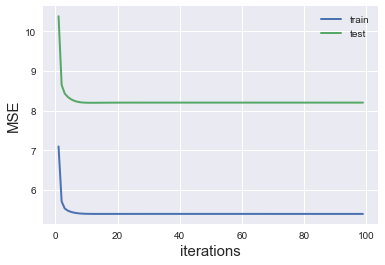

In [41]:
MatrixFactorisation_ALS.PlotError()

Iteration number : 0 	 Train MSE = 2.9282202997 	 Test MSE = 3.01994521195


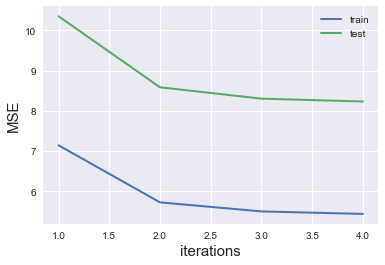

In [45]:
## Stop training early
best_als_model = ExplicitFactorisation(train_type="ALS"
                                            ,ratings=train 
                                            ,latent_features=10
                                            ,user_regularisation=0.01
                                            ,item_regularisation=0.01)
best_als_model.fit(5)
best_als_model.PlotError()

In [19]:
## Try SGD model
MatrixFactorisation_SGD = ExplicitFactorisation(train_type = 'SGD'
                                            ,ratings=train
                                            ,latent_features=40
                                            ,user_regularisation=0.01
                                            ,item_regularisation=0.01
                                            ,item_bias_regularisation=0.01
                                            ,user_bias_regularisation=0.01)
MatrixFactorisation_SGD.fit(100,0.005)

Iteration number : 0 	 Train MSE = 102.645736641 	 Test MSE = 101.216810332
Iteration number : 5 	 Train MSE = 0.8733425995 	 Test MSE = 1.87187656159
Iteration number : 10 	 Train MSE = 0.669012853982 	 Test MSE = 1.51839907472
Iteration number : 15 	 Train MSE = 0.557087638753 	 Test MSE = 1.4294788558
Iteration number : 20 	 Train MSE = 0.476172845083 	 Test MSE = 1.40585148488
Iteration number : 25 	 Train MSE = 0.414607124281 	 Test MSE = 1.40639174495
Iteration number : 30 	 Train MSE = 0.368294070767 	 Test MSE = 1.41753973828
Iteration number : 35 	 Train MSE = 0.332578494028 	 Test MSE = 1.4312543873
Iteration number : 40 	 Train MSE = 0.304747167067 	 Test MSE = 1.4439246841
Iteration number : 45 	 Train MSE = 0.282582586485 	 Test MSE = 1.4578555816
Iteration number : 50 	 Train MSE = 0.264491653577 	 Test MSE = 1.47009569078
Iteration number : 55 	 Train MSE = 0.249685350116 	 Test MSE = 1.48107161045
Iteration number : 60 	 Train MSE = 0.237186479713 	 Test MSE = 1.4908195

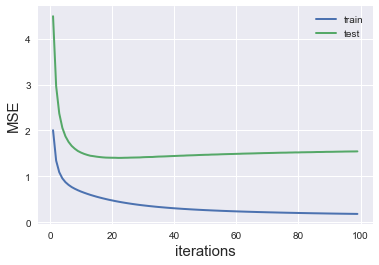

In [20]:
MatrixFactorisation.PlotError()

In [81]:
best_sgd_model = ExplicitFactorisation(train_type = 'SGD'
                                            ,ratings=train
                                            ,latent_features=10
                                            ,user_regularisation=0.01
                                            ,item_regularisation=0.01
                                            ,item_bias_regularisation=0.01
                                            ,user_bias_regularisation=0.01)
best_sgd_model.fit(20,0.005)

Iteration number : 0 	 Train MSE = 7.98879159004 	 Test MSE = 7.57724733979
Iteration number : 5 	 Train MSE = 0.88045755673 	 Test MSE = 1.12041906272
Iteration number : 10 	 Train MSE = 0.798511435011 	 Test MSE = 1.02479299014
Iteration number : 15 	 Train MSE = 0.74784933706 	 Test MSE = 0.998448306704


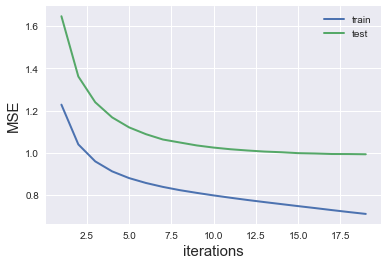

In [82]:
best_sgd_model.PlotError()

In [83]:
from sklearn.metrics.pairwise import cosine_similarity
sgd_sim = cosine_similarity(best_sgd_model.item_vectors,best_sgd_model.item_vectors)
als_sim = cosine_similarity(best_als_model.item_vectors,best_als_model.item_vectors)

def getMovieName(movieID):
    info = df_info.loc[movieID,'movie title']
    return(pd.DataFrame(info).reset_index(drop = True))

In [50]:
## Get movie info
names = ['movie id', 'movie title','release date','video release date',
              'IMDb URL','unknown', 'Action', 'Adventure', 'Animation', 
              'Children''s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi'
              'Thriller', 'War', 'Western ']
df_info = pd.read_csv('ml-100k/u.item', sep='|',names = names, index_col=False)
df_info.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-FiThriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [80]:
ALS_recommendation = np.argsort(als_sim[120,:])[::-1][0:10]
getMovieName(ALS_recommendation)

,movie title
0,Independence Day (ID4) (1996)
1,Mission: Impossible (1996)
2,"Rock, The (1996)"
3,Twister (1996)
4,Toy Story (1995)
5,"Lost World: Jurassic Park, The (1997)"
6,Ransom (1996)
7,Eraser (1996)
8,Broken Arrow (1996)
9,Phenomenon (1996)


In [84]:
SGD_recommendation = np.argsort(sgd_sim[120,:])[::-1][0:10]
getMovieName(SGD_recommendation)

,movie title
0,Independence Day (ID4) (1996)
1,Dave (1993)
2,Die Hard: With a Vengeance (1995)
3,"Rock, The (1996)"
4,"Hunt for Red October, The (1990)"
5,Twister (1996)
6,In the Mouth of Madness (1995)
7,"Firm, The (1993)"
8,"Time to Kill, A (1996)"
9,Sneakers (1992)
